# Association analysis and Recommender Systems


### This project is split into 2 parts.
First we look at the Association analysis for a popular dataset [`Online Retail`](http://archive.ics.uci.edu/ml/machine-learning-databases/00352) followed by Recommender Systems for [MovieLens dataset](http://www.grouplens.org/system/files/ml-1m.zip).

This notebook can be viewed at this link as all images may not render completely: https://nbviewer.jupyter.org/github/iamfarazbaig/assignment3/blob/master/assignment3SpecOriginal.ipynb

In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import requests, os

xlUrl = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
xlFile = 'data/Online Retail.xlsx'
dataFile = xlFile
url = xlUrl
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.isfile(dataFile):
  r = requests.get(url)
  with open(dataFile, 'wb') as f:
    f.write(r.content)
if (dataFile == xlFile):
  df = pd.read_excel(dataFile)
else:
  df = pd.read_csv(dataFile)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Data Cleaning

While Association Analysis does not require rigorous data cleaning, it does make sense to remove extraneous records, such as those with null invoice numbers and canceled orders. It’s also useful to remove extraneous spaces in the product descriptions and convert all the invoice numbers to string.

In [2]:
df['Description'] = df['Description'].str.strip()
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]

### Initial Visualisation of no. of Orders for all Countries
I'm using a log scale just for visualisation as the UK dominates the market

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn import linear_model
from sklearn import metrics
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

grouped  = df.groupby(['Country']).count()['Quantity'].sort_values(ascending=False)

data_plot = [go.Bar(x=grouped.index, y=grouped.values)]
layout = go.Layout(yaxis={'type':'log', 'autorange':True, 'title':'Log10 number of orders'},xaxis={'title':'country'})
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

As we can see that in the `Quantity` column, the count for Germany is equal to the to the number of records required(9042) by hovering over the graph.

Creating subsets of dataframe for each unique country, in this case only Germany
Code source: https://www.kaggle.com/ostrowski/market-basket-analysis-exploring-e-commerce-data

In [4]:
def df_per_country(df):
    import re
    df_dict = {}
    unique_countries, counts = np.unique(df.Country, return_counts=True)
    for country in unique_countries:
        df_dict["df_{}".format(re.sub('[\s+]', '', country))] = df[df.Country == country].copy()
        df_dict["df_{}".format(re.sub('[\s+]', '', country))].drop('Country', axis=1, inplace=True)
    return df_dict

# Trick to convert dictionary key/values into variables
# This way we don't need to access dfs by df_dict['df_France'] for example
df_dict = df_per_country(df)
locals().update(df_dict)

Series plot function summarizing df_Countries

In [5]:
def series_plot(df, by1, by2, by3, period='D'):
    df_ts = df.reset_index().pivot_table(index='InvoiceDate', 
                                values=['InvoiceNo', 'Quantity', 'UnitPrice'], 
                                aggfunc=('count', 'sum'))
    df_ts = df_ts.loc[:, [('InvoiceNo', 'count'), ('Quantity', 'sum'), ('UnitPrice', 'sum')]]
    df_ts.columns = df_ts.columns.droplevel(1)
    plt.figure(figsize=(14, 6))
    
    plt.subplot(2, 2, 1)
    plt.plot(df_ts.resample(period).sum().bfill()[[by1]], color='navy')
    plt.title('{}'.format(by1));
    plt.xticks(rotation=60);
    plt.subplot(2, 2, 2)
    plt.title('{}'.format(by2));
    plt.plot(df_ts.resample(period).sum().bfill()[[by2]], label='Total Sale', color='orange');
    plt.xticks(rotation=60)
    plt.tight_layout()
    
    plt.figure(figsize=(14, 8))
    plt.title('{}'.format(by3));
    plt.plot(df_ts.resample(period).sum().bfill()[[by3]], label='Total Invoices', color='green');
    plt.tight_layout()

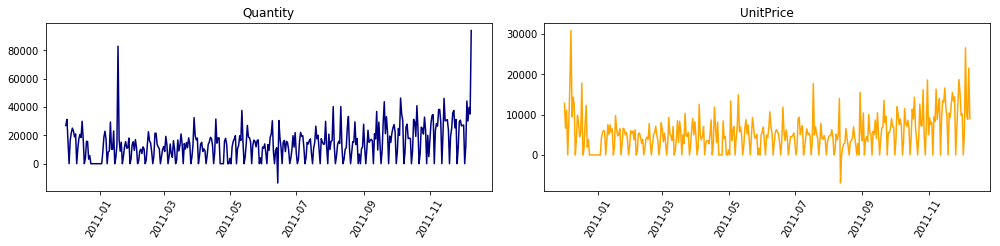

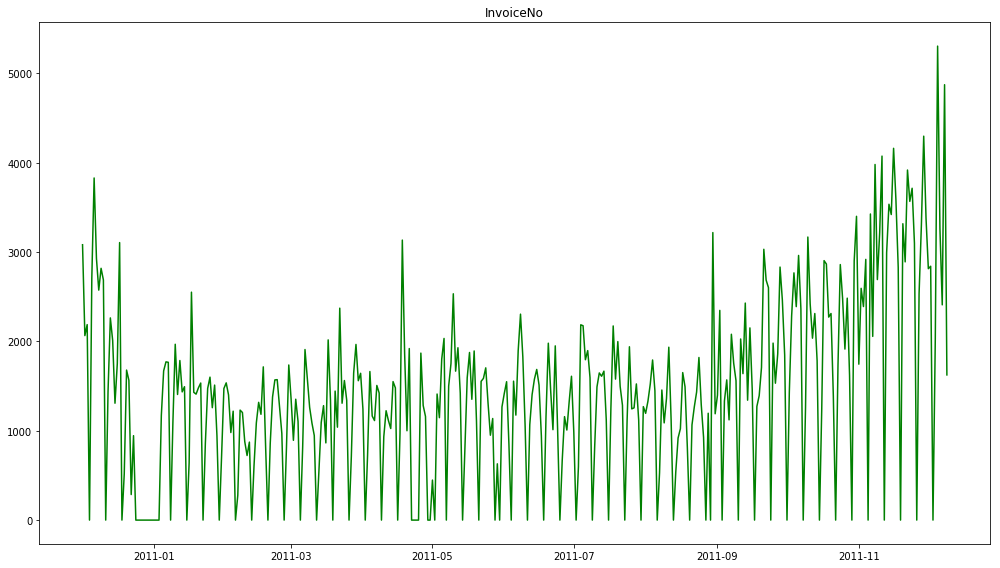

In [6]:
series_plot(df, 'Quantity', 'UnitPrice', 'InvoiceNo')

Next, I’ll rearrange the data with each product one hot encoded and one transaction per row. 
One hot encoding is a data transformation technique where categorical values are converted into columns, with the value of 1 entered where a categorical value is present. 
I will also limit the scope of the dataset to one country, in this case Germany, to compare consumer behavior in an individual market.

In [7]:
basket = (df[df['Country'] =="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket.head(10)

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less the 0 is set to 0. This step will complete the one hot encoding of the data and remove the `Postage` column (since that charge is not one we wish to explore):

In [8]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)
basket_sets.head(10)

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,...,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Enter the following code to view sets of items with at least 2 percent support.
The visualization of this is after a few lines of code.

In [9]:
frequent_itemsets = apriori(basket_sets, min_support= 0.02, use_colnames=True)
frequent_itemsets.sort_values('support', ascending = False).head()

,support,itemsets
178,0.245077,(ROUND SNACK BOXES SET OF4 WOODLAND)
176,0.157549,(ROUND SNACK BOXES SET OF 4 FRUITS)
137,0.137856,(PLASTERS IN TIN WOODLAND ANIMALS)
165,0.137856,(REGENCY CAKESTAND 3 TIER)
441,0.131291,"(ROUND SNACK BOXES SET OF4 WOODLAND, ROUND SNA..."


With the key sets of items identified, I can now apply the association rules library to discover customers’ purchase behaviors with the results sorted by `Lift`

In [10]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print ("Generated {:,} rules".format(len(rules)))
rules.sort_values('lift',ascending = False)

Generated 738 rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
127,(DOLLY GIRL CHILDRENS CUP),(DOLLY GIRL CHILDRENS BOWL),0.024070,0.026258,0.024070,1.000000,38.083333,0.023438,inf
126,(DOLLY GIRL CHILDRENS BOWL),(DOLLY GIRL CHILDRENS CUP),0.026258,0.024070,0.024070,0.916667,38.083333,0.023438,11.711160
69,(BLUE VINTAGE SPOT BEAKER),(PINK VINTAGE SPOT BEAKER),0.030635,0.024070,0.024070,0.785714,32.642857,0.023333,4.554340
68,(PINK VINTAGE SPOT BEAKER),(BLUE VINTAGE SPOT BEAKER),0.024070,0.030635,0.024070,1.000000,32.642857,0.023333,inf
478,"(RED STRIPE CERAMIC DRAWER KNOB, WHITE SPOT RE...",(BLUE STRIPE CERAMIC DRAWER KNOB),0.032823,0.028446,0.021882,0.666667,23.435897,0.020948,2.914661
44,(BLUE OWL SOFT TOY),(PINK OWL SOFT TOY),0.032823,0.028446,0.021882,0.666667,23.435897,0.020948,2.914661
483,(BLUE STRIPE CERAMIC DRAWER KNOB),"(RED STRIPE CERAMIC DRAWER KNOB, WHITE SPOT RE...",0.028446,0.032823,0.021882,0.769231,23.435897,0.020948,4.191101
45,(PINK OWL SOFT TOY),(BLUE OWL SOFT TOY),0.028446,0.032823,0.021882,0.769231,23.435897,0.020948,4.191101
70,(BLUE VINTAGE SPOT BEAKER),(RED VINTAGE SPOT BEAKER),0.030635,0.030635,0.021882,0.714286,23.316327,0.020943,3.392779
71,(RED VINTAGE SPOT BEAKER),(BLUE VINTAGE SPOT BEAKER),0.030635,0.030635,0.021882,0.714286,23.316327,0.020943,3.392779


The results, sorted by `Lift` reveal the purchasing patterns of German customers on the site. We can see that customers who buy `DOLLY GIRL CHILDRENS BOWL` also purchase `DOLLY GIRL CHILDRENS CUP` and other similar pair of items. As far as actionable insights go, it could be recommended to the site owners to offer bundle deals on these items, keeping in mind that this list is sorted by `Lift` and not `occurrence`. It may not make sense to introduce a new bundle or product offering if it isn’t popular enough.

In [11]:
# get stats on objective measures
rules[["support","confidence", "lift"]].describe()

,support,confidence,lift
count,738.000000,738.000000,738.000000
mean,0.028067,0.408796,5.786787
std,0.009774,0.231677,5.338703
min,0.021882,0.089286,1.108245
25%,0.021882,0.207547,2.493552
50%,0.024070,0.375000,3.554444
75%,0.030635,0.551293,6.566092
max,0.131291,1.000000,38.083333


Above, we see summary statistics for the rule quality measures: support, confidence, and lift. Support and confidence should not be very surprising, since we used these as selection criteria for the rules. However, we might be alarmed if most or all of the rules were very near the minimum thresholds—not the case here.

We can filter the dataframe using standard pandas code. In this case, look for a large lift (20) and high confidence (.8):

In [12]:
rules[ (rules['lift'] >= 20) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
68,(PINK VINTAGE SPOT BEAKER),(BLUE VINTAGE SPOT BEAKER),0.024070,0.030635,0.024070,1.000000,32.642857,0.023333,inf
126,(DOLLY GIRL CHILDRENS BOWL),(DOLLY GIRL CHILDRENS CUP),0.026258,0.024070,0.024070,0.916667,38.083333,0.023438,11.711160
127,(DOLLY GIRL CHILDRENS CUP),(DOLLY GIRL CHILDRENS BOWL),0.024070,0.026258,0.024070,1.000000,38.083333,0.023438,inf
431,(SET/10 BLUE POLKADOT PARTY CANDLES),(SET/10 PINK POLKADOT PARTY CANDLES),0.032823,0.037199,0.026258,0.800000,21.505882,0.025037,4.814004
446,(SPACEBOY CHILDRENS CUP),(SPACEBOY CHILDRENS BOWL),0.043764,0.041575,0.037199,0.850000,20.444737,0.035380,6.389497
447,(SPACEBOY CHILDRENS BOWL),(SPACEBOY CHILDRENS CUP),0.041575,0.043764,0.037199,0.894737,20.444737,0.035380,9.084245
707,"(SPACEBOY CHILDRENS CUP, ROUND SNACK BOXES SET...",(SPACEBOY CHILDRENS BOWL),0.024070,0.041575,0.021882,0.909091,21.866029,0.020881,10.542670


Looking at the rules, it seems that the `PINK VINTAGE SPOT BEAKER` and `BLUE VINTAGE SPOT BEAKER` are purchased together in a manner that is higher than the overall probability would suggest.

At this point, we can want to look at how much opportunity there is to use the popularity of one product to drive sales of another. For instance, we can see that we sell 104 `PINK VINTAGE SPOT BEAKER`  and 136 `BLUE VINTAGE SPOT BEAKER`. So maybe we can drive more `PINK VINTAGE SPOT BEAKER` sales through recommendations?

In [13]:
basket['PINK VINTAGE SPOT BEAKER'].sum()

104.0

In [14]:
basket['BLUE VINTAGE SPOT BEAKER'].sum()

136.0

In [15]:
# add new columnn storing the rule length
rules["rule_len"] = rules.apply(lambda row: len(row["antecedents"])+len(row["consequents"]), axis=1)

In [16]:
# get stats on rules groupt by rule length
rules[["rule_len","support", "lift"]].groupby("rule_len").agg(['mean', 'count']).reset_index()

rule_len   support            lift      
                mean count      mean count
0        2  0.029303   460  5.777915   460
1        3  0.026010   264  5.824470   264
2        4  0.026258    14  5.367698    14

Restricting analysis to rules of length 3 and order rules by lift

In [17]:
rules[rules["rule_len"]==3].sort_values(by='lift',ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,rule_len
478,"(RED STRIPE CERAMIC DRAWER KNOB, WHITE SPOT RE...",(BLUE STRIPE CERAMIC DRAWER KNOB),0.032823,0.028446,0.021882,0.666667,23.435897,0.020948,2.914661,3
483,(BLUE STRIPE CERAMIC DRAWER KNOB),"(RED STRIPE CERAMIC DRAWER KNOB, WHITE SPOT RE...",0.028446,0.032823,0.021882,0.769231,23.435897,0.020948,4.191101,3
710,(SPACEBOY CHILDRENS BOWL),"(SPACEBOY CHILDRENS CUP, ROUND SNACK BOXES SET...",0.041575,0.024070,0.021882,0.526316,21.866029,0.020881,2.060297,3
707,"(SPACEBOY CHILDRENS CUP, ROUND SNACK BOXES SET...",(SPACEBOY CHILDRENS BOWL),0.024070,0.041575,0.021882,0.909091,21.866029,0.020881,10.542670,3
677,"(RED STRIPE CERAMIC DRAWER KNOB, WHITE SPOT RE...",(RED SPOT CERAMIC DRAWER KNOB),0.032823,0.030635,0.021882,0.666667,21.761905,0.020876,2.908096,3


Looking at the rules, it seems that the `ROUND SNACK BOXES SET OF4 WOODLAND , RED RETR...` and `WOODLAND CHARLOTTE BAG` are purchased together in a manner that is higher than the overall probability would suggest.

At this point, we could look at how much opportunity there is to use the popularity of one product to drive sales of another. For instance, if the sales of  `ROUND SNACK BOXES SET OF4 WOODLAND , RED RETR...` are decreasing then maybe we can drive more `CHARLOTTE SUKI DESIGN` bag sales through recommendations?

To represent association rules as diagram, NetworkX python library is utilized
Code sourced from : http://intelligentonlinetools.com/blog/2018/02/10/how-to-create-data-visualization-for-association-rules-in-data-mining/

In [18]:
def draw_graph(rules, rules_to_show):
  import networkx as nx  
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 50
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
   
  for i in range (rules_to_show):      
    G1.add_nodes_from(["R"+str(i)])
    
     
    for a in rules.iloc[i]['antecedents']:
                
        G1.add_nodes_from([a])
        
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
    for c in rules.iloc[i]['consequents']:
             
            G1.add_nodes_from([c])
            
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
  for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')       
 
 
   
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)

Directed graph below is built for this rule. Arrows are drawn as just thicker blue stubs. The node with R0 identifies one rule, and it will have always incoming and outcoming edges. Incoming edge(s) will represent antecedants and the stub (arrow) will be next to node.

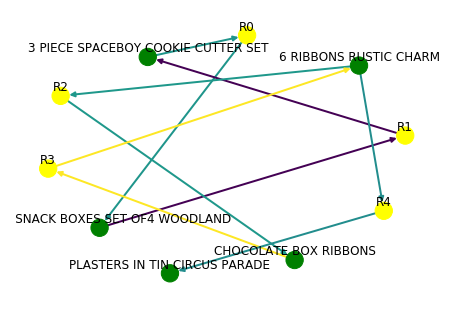

In [19]:
draw_graph (rules, 5) 

### Visualizing the rules distribution color mapped by Lift

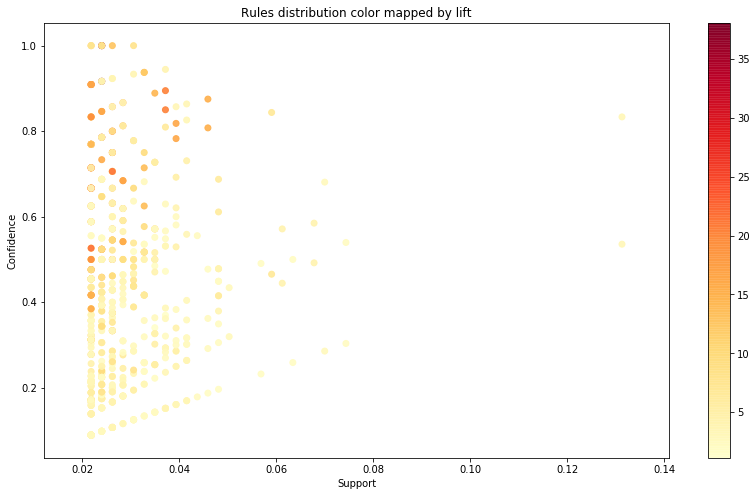

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], alpha=0.9, cmap='YlOrRd');
plt.title('Rules distribution color mapped by lift');
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar();

## Recommender Systems

We use the well-known [MovieLens dataset](http://www.grouplens.org/system/files/ml-1m.zip) (in this case the 1M version). 

Get detail about the dataset in the README. http://files.grouplens.org/papers/ml-1m-README.txt

### Importing Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn import linear_model
from sklearn import metrics

### Load the data

In [22]:
user   = pd.read_csv('users.dat',sep="::",lineterminator='\r',header=None)
movies = pd.read_csv('movies.dat',sep="::",lineterminator='\r',header = None)
rating = pd.read_csv('ratings.dat',sep="::",lineterminator='\r',header = None)

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.

C:\Users\faraz\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [23]:
print (user.head())
print (movies.head())
print (rating.head())

   0  1   2   3      4
0  1  F   1  10  48067
1  2  M  56  16  70072
2  3  M  25  15  55117
3  4  M  45   7  02460
4  5  M  25  20  55455
   0                                   1                             2
0  1                    Toy Story (1995)   Animation|Children's|Comedy
1  2                      Jumanji (1995)  Adventure|Children's|Fantasy
2  3             Grumpier Old Men (1995)                Comedy|Romance
3  4            Waiting to Exhale (1995)                  Comedy|Drama
4  5  Father of the Bride Part II (1995)                        Comedy
   0     1  2          3
0  1  1193  5  978300760
1  1   661  3  978302109
2  1   914  3  978301968
3  1  3408  4  978300275
4  1  2355  5  978824291


In [24]:
user.columns = ['UserID','Gender','Age','Occupation','Zip Code']
movies.columns = ['MovieID','Title','Genres']
rating.columns = ['UserID','MovieID','Rating','Timestamp (s)']

In [25]:
print(user.columns)
print(movies.columns)
print(rating.columns)

Index(['UserID', 'Gender', 'Age', 'Occupation', 'Zip Code'], dtype='object')
Index(['MovieID', 'Title', 'Genres'], dtype='object')
Index(['UserID', 'MovieID', 'Rating', 'Timestamp (s)'], dtype='object')


Merging all the data into one DataFrame `lens`

In [26]:
movie_ratings = pd.merge(movies, rating)
lens = pd.merge(movie_ratings, user)

### Exploratory Data Analysis

Let's explore the data a bit and get a look at some of the most rated movies.

In [27]:
most_rated = lens.groupby('Title')['Rating'].count().sort_values(ascending=False).head()
most_rated

Title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Name: Rating, dtype: int64

In [28]:
ratings_df = pd.DataFrame(lens.groupby('Title')['Rating'].mean())
ratings_df['num_of_ratings'] = pd.DataFrame(lens.groupby('Title')['Rating'].count())

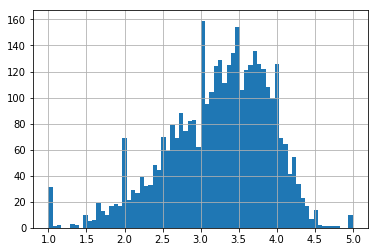

In [29]:
ratings_df['Rating'].hist(bins=70)

We can see that most movies are distributed around 3.0 to 4.0 ratings.The peaks observed at some whole numbers like 1.0, 2.0  and 3.0  can be made sense as to the way people rate movies and probably these movies have fewer people watching them. We could term these as possible outliers due to their relatively fewer occurances.

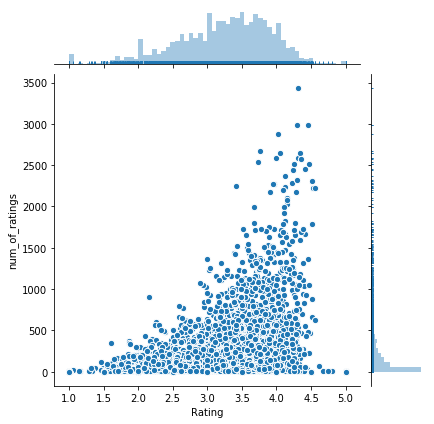

In [30]:
sns.jointplot(x="Rating", y='num_of_ratings', data=ratings_df,marginal_kws=dict(bins=60, rug=True),annot_kws=dict(stat="r"), s=40, edgecolor="w", linewidth=1)

Looking at this data, we can see that as a movie get more ratings, it is more likely for the movie to have a higher rating. It makes sense because, if a movie is good, more people may watch it and if more people watch it, it more likely to have a higher number of people rating it. Hence it also makes sense that the 1,2,5 star rated movies are lesser which could be classified as outliers.

Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system.

### Filtering

The following code filters the number of Movies. Choosing a small threshold of 100 ensures that movies with that number of aggregate ratings will be considered.

In [31]:
minMovieRatings = 100
filterMovies = lens['MovieID'].value_counts() > minMovieRatings
filterMovies = filterMovies[filterMovies].index
filterMovies = lens[lens['MovieID'].isin(filterMovies)]
print('from length:', len(lens))
print('to length:', len(filterMovies))

from length: 1000209
to length: 940925


###  Generate the distribution of ratings

First, we look at the Count of` Ratings` per `UserID` and Count of `Ratings` per `MovieID`.
Then, we observe the difference when we use Average instead of Count

Count of the `Ratings` per `UserID` and the plot of this data with a histogram

In [32]:
movie_stats = pd.DataFrame(filterMovies.groupby('UserID')['Rating'].count())
movie_stats.head()

,Rating
UserID,
1,52
2,125
3,50
4,21
5,174


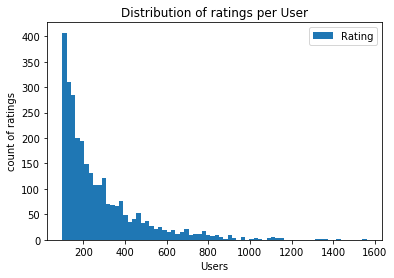

In [33]:
atleast_100 = movie_stats['Rating'] >= 100
movie_stats[atleast_100].plot.hist(bins=70)
plt.title("Distribution of ratings per User")
plt.ylabel('count of ratings')
plt.xlabel('Users');

Count of the `Ratings` per `MovieID` and the plot of this data with a histogram

In [34]:
temp = pd.DataFrame(filterMovies.groupby('MovieID')['Rating'].count())
atleast_100 = temp['Rating'] >= 100
filtered = temp[atleast_100]
filtered.head()

,Rating
MovieID,
1,2077
2,701
3,478
4,170
5,296


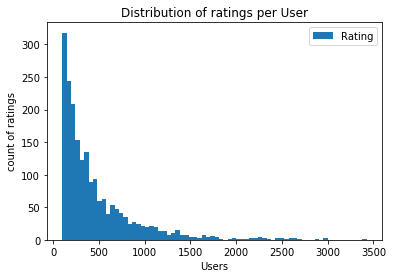

In [35]:
filtered.plot.hist(bins=70)
plt.title("Distribution of ratings per User")
plt.ylabel('count of ratings')
plt.xlabel('Users');

Average of the `Ratings` per `UserID` and the plot of this data in a histogram

In [36]:
movie_stats = pd.DataFrame(filterMovies.groupby('UserID')['Rating'].mean())

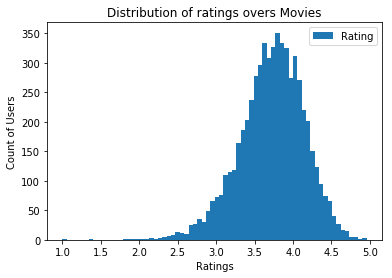

In [37]:
movie_stats.plot.hist(bins=70)
plt.title("Distribution of ratings overs Movies")
plt.ylabel('Count of Users')
plt.xlabel('Ratings');

We can see that most movies are distributed around 3.0 to 4.0 ratings.The few values observed at some numbers like 1.0, 2.0 and 5.0 can be made sense as to the way people rate movies and probably these movies have fewer people watching them. We could term these as possible outliers due to their relatively fewer occurances.

Average of the `Ratings` per `MovieID` and the plot of this data with a histogram

In [38]:
movie_stats = pd.DataFrame(lens.groupby('MovieID')['Rating'].mean())
movie_stats.head()

,Rating
MovieID,
1,4.146846
2,3.201141
3,3.016736
4,2.729412
5,3.006757


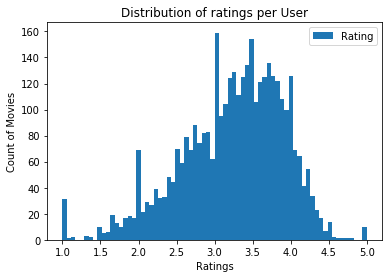

In [39]:
movie_stats.plot.hist(bins=70)
plt.title("Distribution of ratings per User")
plt.ylabel('Count of Movies')
plt.xlabel('Ratings');

The distributions look similar to that with UserID but here we have more pronounced peaks at ratings 1,2,5.

Here, I have increased the minimum movie rating count from 100 to 1000 in order to reduce computational time

In [40]:
minMovieRatings = 1000
filterMovies = lens['MovieID'].value_counts() > minMovieRatings
filterMovies = filterMovies[filterMovies].index
filterMovies = lens[lens['MovieID'].isin(filterMovies)]
print('from length:', len(lens))
print('to length:', len(filterMovies))

from length: 1000209
to length: 305373


### Using Prediction Algorithms

Surprise provides a bunch of built-in algorithms. Here, `SVD()`, `SlopeOne()`, `NMF()` and `KNNBasic()` have been used. The code for looping through the respective algorithms is sourced from
https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

In [41]:
import pandas as pd
from surprise import SVD
from surprise import SlopeOne
from surprise import NMF
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Creation of the dataframe. Column names are irrelevant.
ratings_dict = {'userID': filterMovies['UserID'],
                'itemID': filterMovies['MovieID'],
                'rating': filterMovies['Rating']}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
results_table = []
for algorithm in [SVD(), SlopeOne(), NMF(), KNNBasic()]:
    #running 3 fold cross validation
    results = cross_validate(algorithm, data, measures = ['RMSE', 'MAE'], cv = 3, verbose = True)
    
    #pushing algo names into results
    data_final = pd.DataFrame.from_dict(results).mean(axis = 0)
    data_final = data_final.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index = ['Algorithm']))
    results_table.append(data_final)
pd.DataFrame(results_table).set_index('Algorithm').sort_values('test_rmse')

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8677  0.8700  0.8700  0.8692  0.0011  
MAE (testset)     0.6794  0.6805  0.6804  0.6801  0.0005  
Fit time          20.81   20.57   20.18   20.52   0.26    
Test time         1.44    1.32    1.80    1.52    0.21    
Evaluating RMSE, MAE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8857  0.8857  0.8875  0.8863  0.0009  
MAE (testset)     0.6916  0.6923  0.6926  0.6922  0.0004  
Fit time          0.78    0.81    0.81    0.80    0.01    
Test time         9.29    9.11    9.31    9.24    0.09    
Evaluating RMSE, MAE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9006  0.8973  0.9040  0.9006  0.0027  
MAE (testset)     0.7094  0.7034  0.7091  0.7073  0.0028  
Fit time          20.57   23.68   24.81   23.02   1.79    
Test ti

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.869231,0.680127,20.519792,1.518942
SlopeOne,0.886308,0.692162,0.802524,9.235631
NMF,0.900623,0.707270,23.020115,1.414833
KNNBasic,0.909910,0.711571,26.369369,168.170674


We use `rmse` as our accuracy metric. Here, we can see that, SlopeOne algorithm strikes the best balance between lower `rmse` value and lower fit and test time in comparision to other algorithms. In particular KNNBasic took the highest time to process. SVD++ was initially my choice instead of SVD but given the size of the dataset and looking at the processing time it took in some cases which I found on the internet(over 2 hours), I chose not to include it.